## PS 4
## Olivia Natan


In [1]:
import numpy as np
import scipy.stats as sts
import pandas as pd
import seaborn as sns
import numpy.linalg as lin
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

### Setup

In this problem, we have data on the distribution of households across income brackets, and we are going to do some moment matching via GMM

##### Data setup:

The data are stored as tab-delimited data in 42 bins in 'usincmoms.txt', the first number is the bin midpoint, the second is the percent of the population (indivs vs hhs?) in the bin. 

First, we import the data

In [2]:
df = pd.read_csv('usincmoms.txt',delim_whitespace=True,header=None,names=['Percent','Midpoint'])
df.head()

,Percent,Midpoint
0,0.035190,2500
1,0.041062,7500
2,0.058859,12500
3,0.056836,17500
4,0.058595,22500


Next, we add endpoints to the ranges:

In [3]:
df['bottom'],df['top'] = None, None
df.loc[0,'bottom']= 0
df.loc[0,'top'] = df.loc[0,'Midpoint'] + (df.loc[0,'Midpoint']-df.loc[0,'bottom'])
for j in df.index[1:]:
    df.loc[j,'bottom'] = df.loc[j-1,'top']
    df.loc[j,'top'] =df.loc[j,'Midpoint'] + (df.loc[j,'Midpoint']-df.loc[j,'bottom'])
df['range_text'] = df['bottom'].astype(str) + " to "+(df['top']-1).astype(str)
df['midpoint_000s'] = df['Midpoint']/1000
df['binwidth'] = (df.top - df.bottom)/1000
df['percent_bar'] = df['Percent']
df.loc[40,'percent_bar'] = df.loc[40,'percent_bar']/10
df.loc[41,'percent_bar'] = df.loc[41,'percent_bar']/20
df.tail()

,Percent,Midpoint,bottom,top,range_text,midpoint_000s,binwidth,percent_bar
37,0.002998,187500,185000,190000,185000 to 189999,187.5,5,0.002998
38,0.003138,192500,190000,195000,190000 to 194999,192.5,5,0.003138
39,0.002577,197500,195000,200000,195000 to 199999,197.5,5,0.002577
40,0.018970,225000,200000,250000,200000 to 249999,225.0,50,0.001897
41,0.023190,300000,250000,350000,250000 to 349999,300.0,100,0.001160


# Part A

We want to display the histogram for this data. We have set above the bin width to correspond with range size (normalized to 1000s). 

Each bar should be centered at the normalized midpoint, with specified width, and height of df['Percent']

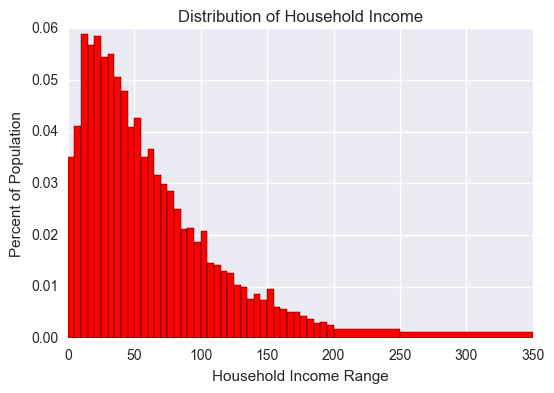

In [4]:
fig, ax = plt.subplots()
rects1 = ax.bar(df['bottom']/1000, df['percent_bar'], df['binwidth'], color='r')
ax.set_ylabel('Percent of Population')
ax.set_xlabel('Household Income Range')
ax.set_title('Distribution of Household Income')

# Part B

## GMM to fit lognormal dist

We want to estimate the mean and variance parameters to match the moments of the data to the predicted lognormal distribution.

In [5]:
import scipy.stats as sts

def errors_lognorm(params, *args):
    # Function to return a 42x1
    mu, sigma = params
    pdf_vals, bottom_points,top_points = args
    bottom_points[0] = 0.5
    lower_cdfval = sts.norm.cdf(np.log(list(bottom_points)),loc=mu,scale=sigma)
    upper_cdfval = sts.norm.cdf(np.log(list(top_points)),loc=mu,scale=sigma)
    lower_cdfval[0]=0
    upper_cdfval[41]=1
    prob_int = upper_cdfval - lower_cdfval # difference the CDFs to find out interval probability
    error_vec = pdf_vals - prob_int
    return np.array(error_vec)

def crit_lognorm(params, *args):
    mu, sigma = params
    pdf_vals, bottom_points, top_points, W = args
    errors = errors_lognorm([mu,sigma],pdf_vals, bottom_points,top_points)
    objective = np.dot(np.dot(errors.T, W), errors) 
    return objective

In [6]:
crit_lognorm([5000,2500],df['Percent'],df['bottom'],df['top'],np.eye(42))

C:\Users\Olivia\Anaconda\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.94538158884705625

In [7]:
# optimizing
import scipy.optimize as opt
gmm_init = [5000,1000] # initial values
W_init = np.multiply(df['Percent'].values,np.eye(42))
gmm_args = (df['Percent'],df['bottom'],df['top'],W_init)
results = opt.minimize(crit_lognorm, gmm_init, args=(gmm_args), method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)

C:\Users\Olivia\Anaconda\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


('mu_GMM1=', 5000.0, ' sig_GMM1=', 1000.0)


In [8]:
results

      fun: 0.023789328370220554
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  0.00000000e+00,  -6.93889390e-10])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
   status: 0
  success: True
        x: array([ 5000.,  1000.])

In [91]:
W_init

array([[ 0.03519016,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.04106206,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.05885948, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.0025767 ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.01897015,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.02319032]])